# SIR

In [5]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import os
import sys
import glob
import time
import warnings
import datetime 
print("Last updated on ", time.asctime())

Last updated on  Sat Apr  4 11:49:05 2020


In [7]:
import numpy as np
import pandas as pd
import matplotlib

In [8]:
fontsize=20
font = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': fontsize,
        }

plt.rcParams["font.size"     ] = fontsize


In [9]:
from scipy.integrate import odeint
import scipy.integrate as spi
from scipy.interpolate import interp1d


In [10]:
from dataclasses import dataclass, field

In [11]:
from c19.types import SIR, SEIR

In [12]:
import c19.basic_models as cbm
import c19.core_functions as cf
import c19.plotting as cplt
import c19.utils as ut

In [13]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [21]:
from IPython.display import Image

# Modelo SEIR extendido (I)

En la versión más sencilla de SEIR no se distingue entre los individuos que se recuperan y los que fallecen. En esta extensión vamos a añadir este factor. Las ecuaciones son:

$$
\frac{dS}{dt} = - \frac{\beta}{N} S I \\
\frac{dE}{dt} = \frac{\beta}{N} I - \sigma E \\
\frac{dI}{dt} = \sigma E - \gamma I \\
\frac{dR}{dt} = (1 - \phi) \gamma I \\
\frac{dD}{dt} = \phi \gamma I -g D \\
M =g D \\
P = gD - \lambda P
$$

En el modelo SIR teníamos tres ecuaciones que describían la transición entre las categorías S, I y R. En el modelo SEIR, tenemos una ecuación más tal como se muestra en la figura. 

![title](sir-seir.png)


En este caso, la población de S (susceptibles) disminuye a favor de la población E (expuestos) en lugar de hacerlo directamente a favor de I (infectados). De E a I se pasa mediante una tasa controlada por la inversa del tiempo de incubación (a medida que los expuestos alcanzan dicho tiempo se transforman en infecciosos y saltan de categoría) y de I a R se pasa mediante una tasa controlada por el tiempo de recuperación. SEIR se define por tanto en términos de dos parámetros que ya conocíamos, a saber, la tasa de recuperación ($\gamma  = 1/T$, donde T es el tiempo requerido para recuperarse, o lo que es lo mismo el tiempo que se permanece infeccioso) y el producto de la tasa de contacto y la probabilidad de transmisión ($\beta$) ---recordemos que el número de reproducción básica se obtiene a partir de estos dos, $R_0 = \beta/\gamma$. A estas cantidades añadimos una tercera, la tasa de infección, $\sigma$ ($\sigma = 1/T_i$, donde $T_i$ es el tiempo de incubación de la enfermedad, con un valor típico de 5 días [Backer JA, Klinkenberg D, Wallinga J. The incubation period of 2019-nCoV infections among travellers from Wuhan, China. medRxiv 2020; published online Jan 28. DOI:10.1101/2020.01.27.20018986 ]). 


El programa interactivo permite estudiar como evolucionan las cuatro poblaciones en función de T, $T_i$ y $R_0$.  Los resultados pueden presentarse en términos de la fracción relativa de la población, o en términos absolutos, especificando el valor de la población total, N. También puede variarse la fracción de la población que está en cuarentena (medidas de contención). Si el 100 % o más de la población está en cuarentena la epidemia desaparece, mientras que para valores entre 0 y 100 % la curva se aplana (también hay controles para visualizar el tiempo total de la infección). 

Como ejemplo, podemos empezar por fijar los parámetros a los siguientes valores: $R_0=3.5$, $T = 5$ días, $T_i =5$ días. N = 47 millones (población aproximada de España), Q=0 (no hay población en cuarentena) y tf=100 (para ver bien la escala temporal). El modelo nos dice que el pico de la infección se alcanza hacia el día 50 y el número de infectados ese día es algo más de 800,000. La enfermedad necesita unos 80-90 días para agotarse, y en ese momento la mayor parte de la población se ha contagiado y se ha recuperado (recordemos que SIR cuenta las defunciones como "recuperados").

Si ahora fijamos Q a un valor intermedio (Q = 50 %) y alargamos la escala de tiempo hasta 200 días (tf = 200) vemos que la curva de infección "se aplana", el pico llega mucho más tarde (a los 120 días) y es más bajo (menos de trescientos mil infectados en el pico). Aún así, la fracción de la población que se infecta al final es alta (del orden del 70%, podemos verlo quitando el click de la casilla "absolute").  

Para valores de Q lo bastante grandes (~70 %) podemos ver que la infección desaparece... pero no olvidar que esta versión simple del modelo no toma en cuenta un posible repunte. 


## Frozen example

In [46]:
N                = 4.7e+7
ND               = 800
TS               = 1.0
t_start          = 0.0 
t_end            = ND 
t_inc            = TS
t_range          = np.arange(t_start, t_end+t_inc, t_inc)
RX, Gamma, Sigma = 3.5, 1./5, 1./5. 
Beta             = Gamma * R0
I0, E0           = 1E-4, 1E-4
S0               = 1 - I0 - E0
Y0               = (S0, E0, I0)


In [47]:
seir = cbm.compute_seir(N, Y0, RX, Gamma, Sigma, t_range, ts = [(0, 400)], ms=[1.0])

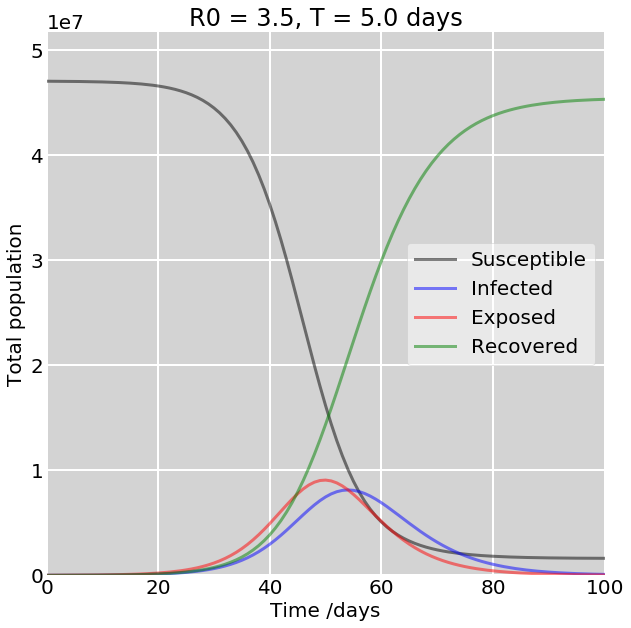

In [50]:
cplt.plot_seir(seir, f"R0 = {RX}, T = {1/Gamma} days", absolute=True,
             tmin = 0, tmax = 100, figsize=(10,10))

# Interactive example

In [56]:
def seir_deriv(y, t, M, beta, gamma, sigma):
    """
    Prepare differential equations for SEIR
    Includes a mitigation function
    """

    S, E, I = y
    dSdt = -beta * M(t) * S * I
    dEdt = beta * M(t) * S * I - sigma * E
    dIdt = sigma * E - gamma * I
    return dSdt, dEdt, dIdt


In [52]:
def mitigation_function(t, ts = [(0, 400)], ms=[1]):
    """Defines a mitigation function as follows:
    1) the time of the infection, t, is divided in tranches specified by ts. Thus, for example,
    ts =[(0,20), (20,60), (60,100)] would divide a time vector of 100 days in 3 tranches,
    the first one
    from day 0 to day 20 and so on.
    2) ms corresponds to the mitigation factor in each tranch. Thus, [(1, 0.5, 0.8)] in the
    example would
    mean that the first tranch no mitigation is applied (R0 * 1), and for second and third
    tranches the
    mitigation would be (R0 * 0.5) and (R0 * 0.8)
    """
    def mitigation(t, ts, ms):
        lt = len(t)
        lm = len(ms)
        x = int(lt /lm)
        c = np.ones(lt)
        for i, tsi in enumerate(ts):
            c[tsi[0]:tsi[1]] = ms[i]
        c[-1] = ms[-1]
        return c

    C = mitigation(t, ts, ms)
    M = interp1d(t, C, bounds_error=False, fill_value="extrapolate")
    return M


In [63]:
def set_pretty_ax(ax, facecolor, xlabel, ylabel, xmin, xmax, ymax):
    ax.set_facecolor(facecolor)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_ylim(0,ymax)
    ax.set_xlim(xmin,xmax)
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.ticklabel_format(axis="both", style="", scilimits=None) 
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)


In [66]:
figsize=(20,10)
facecolor='LightGrey'
@interact
def plint_sir(N=(1.e+5, 1.e+7), T=5., Ti=5, R0=3.5, t0 = fixed(0), tf = (50, 800), Q = (0., 100.), absolute=True):
    """interactive SIR"""
    
    def get_labels(absolute):
        xlabel = 'Tiempo en días'
        if absolute:
            ylabel = 'Población total'
        else:
            ylabel = 'Fracción de la población'
        return xlabel, ylabel

    
    Gamma = 1/T
    Sigma = 1/Ti
    Beta  = Gamma * R0
    ts =[(0, ND)]
    ms = [1 - Q/100]
    M = mitigation_function(t_range, ts, ms)
    ret = odeint(seir_deriv, Y0, t_range, args=(M, Beta, Gamma, Sigma))
    S, E, I = ret.T
    R       = 1 - S - E - I
    sir     = SEIR(N = N, S=S, I=I, E=E, R=R,
                     beta=Beta, R0=R0, gamma=Gamma, sigma = Sigma, t= t_range)

    if absolute:
        S = sir.S * sir.N
        I = sir.I * sir.N
        E = sir.E * sir.N
        R = sir.R * sir.N
        Y = 1.1 * sir.N
    else:
        S = sir.S
        I = sir.I
        E = sir.E
        R = sir.R
        Y = 1.1
    
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(1,2,1, axisbelow=True)

    ax.plot(sir.t, S, 'b', alpha=0.5, lw=3, label='Susceptible')
    ax.plot(sir.t, R, 'r', alpha=0.5, lw=3, label='Recuperados')
    xlabel, ylabel = get_labels(absolute)
    set_pretty_ax(ax, facecolor, xlabel, ylabel, t0, tf, Y)

    ax = fig.add_subplot(1,2,2, axisbelow=True)
    ax.plot(sir.t, E, 'b', alpha=0.5, lw=3, label='Expuestos')
    ax.plot(sir.t, I, 'r', alpha=0.5, lw=3, label='Infectados')
    xlabel, ylabel = get_labels(absolute)

    if absolute:
        Y = 0.20 * sir.N
    else:
        Y = 0.20
    set_pretty_ax(ax, facecolor, xlabel, ylabel, t0, tf, Y)

    title=f"R0 = {R0}, T = {T}, Ti ={Ti}"
    plt.title(title)
    plt.show()



interactive(children=(FloatSlider(value=5050000.0, description='N', max=10000000.0, min=100000.0), FloatSlider…